# Link Prediction on Node Pairs

## 1. Import required packages and define functions

In [41]:
import os
import math
import shutil
import config
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [42]:
def show_graph_info(graph):
    # Compute the number of nodes and edges of the graph
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    # Compute in-degree and out-degree of each node
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())
    # Compute average in-degree and out-degree
    avg_in_degree = sum(in_degrees.values()) / len(in_degrees)
    avg_out_degree = sum(out_degrees.values()) / len(out_degrees)
   # Create a table with the graph information
    table = [
        ["Number of nodes", num_nodes],
        ["Number of edges", num_edges],
        ["Average in-degree", f"{avg_in_degree:.2f}"],
        ["Average out-degree", f"{avg_out_degree:.2f}"]
    ]
    # Print the table
    print(tabulate(table, headers=["Metrices", "Value"]))


In [43]:
def add_missing_edges(df, num_missing_edges=12000, graph=None):
    """Adds missing edges to the given graph by randomly selecting node pairs 
    with no edges between them and adding them to a set. If the shortest path 
    length between the two nodes is greater than 2, the pair is added to a 
    dataframe and returned.

    Args:
        df (pandas.DataFrame): The input graph dataframe with columns 'node1', 'node2', and 'label'.
        num_missing_edges (int): The number of missing edges to generate. Default is 12000.
        G (networkx.Graph): The input graph. If not provided, a new graph is created using df.

    Returns:
        pandas.DataFrame: The input graph dataframe with missing edges added and labeled as 0.
    """
    # Create graph if not provided
    if graph is None:
        graph = nx.from_pandas_edgelist(df, 'node1', 'node2')

    # Generate missing edges from given graph
    # A key-value pair represents a pair of nodes, with the value indicating the link status
    # ('1' for linked and '-1' for unlinked).
    edges = {}

    # Loop through each row of the DataFrame
    for row in df.itertuples(index=False):
        # Add the edge to the dictionary
        edges[(row[0], row[1])] = 1

    # Create a set to add missing edges
    missing_edges = set([])

    while (len(missing_edges) < num_missing_edges):
        a = random.randint(1, 10230)
        b = random.randint(1, 10230)
        tmp = edges.get((a, b), -1)

        # Check if the edge between them is present in the dict
        # Also, chosen nodes can't be the same
        if tmp == -1 and a != b:
            try:
                # Adding points who less likely to be friends
                if nx.shortest_path_length(graph, source=a, target=b) > 2:
                    # If the shortest path between two nodes is greater than two, we add them to our missing set.
                    missing_edges.add((a, b))
                else:
                    continue
            except:
                missing_edges.add((a, b))
        else:
            continue

    df_missing_edges = pd.DataFrame(list(missing_edges), columns=['node1', 'node2'])
    df_missing_edges['label'] = 0
    df = pd.concat([df, df_missing_edges], ignore_index=True)

    return df

## 2. Exploratory Data Analysis

1. Plot the graph

Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17


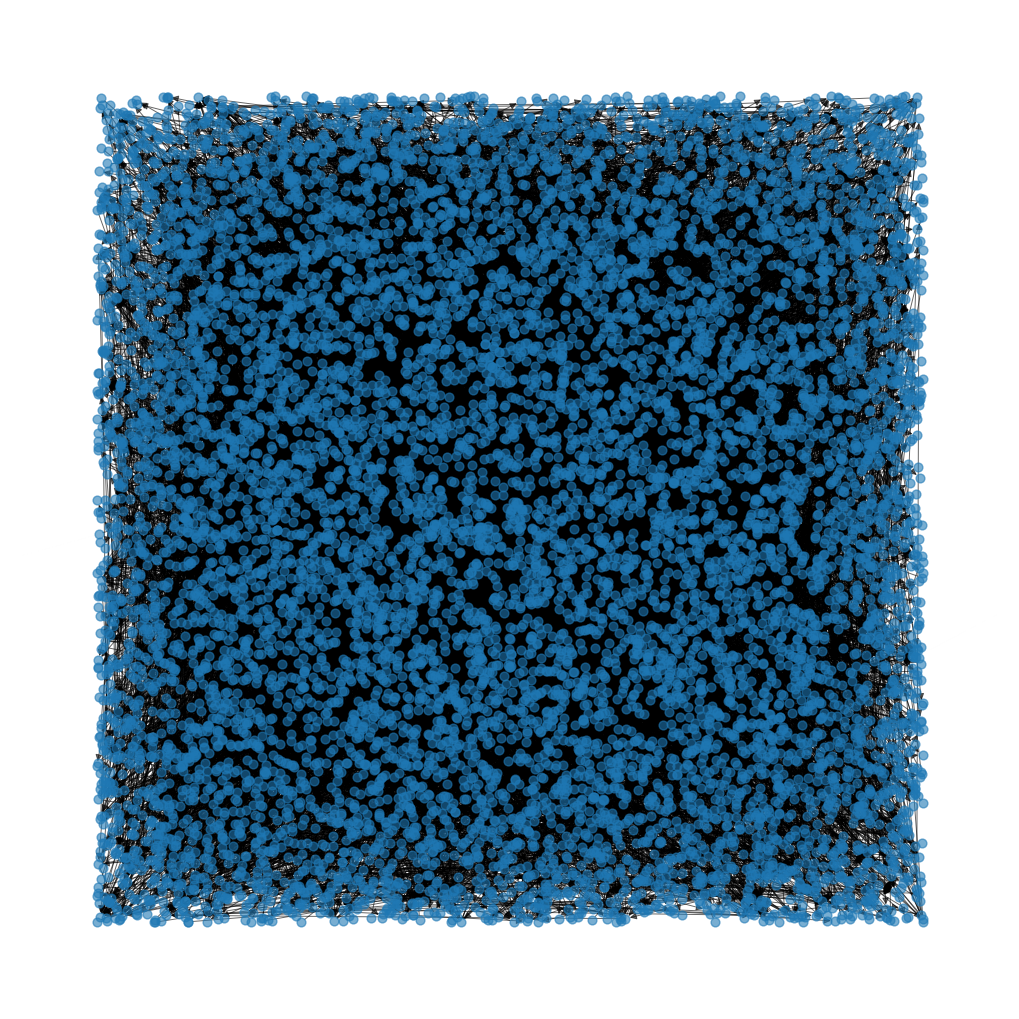

In [44]:
# Load the training dataset
df = pd.read_csv(config.TRAIN_CSV)
# Generate the graph with node pairs with label == 1
G = nx.from_pandas_edgelist(df[df['label'] == 1], "node1", "node2", create_using=nx.DiGraph())
# Check the number of nodes and edges in the original dataset
show_graph_info(G)

# Plot graph
plt.figure(figsize=(10,10))
pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos=pos, node_size=40, alpha=0.6, width=0.7)
# Save the figure
plt.savefig("imgs/train_graph.png")
plt.show()

2. Plot the distribution of number of followers and followees of each node in the training set.

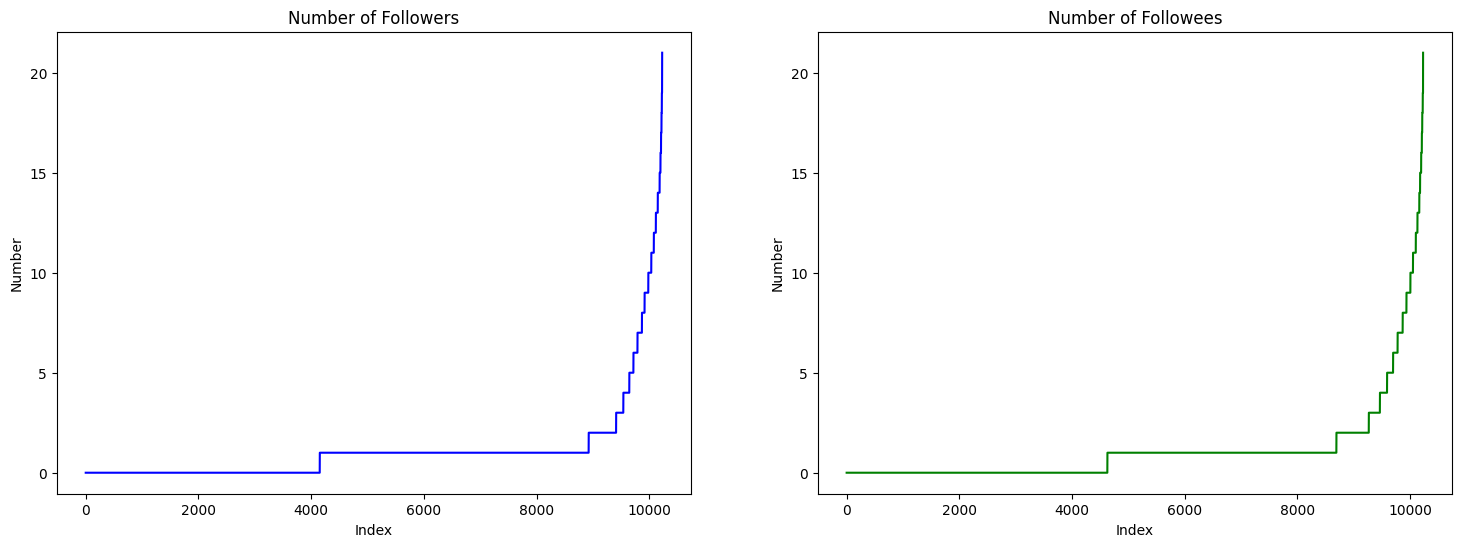

In [45]:
indegree_dist = list(dict(G.in_degree()).values())
indegree_dist.sort()
outdegree_dist = list(dict(G.out_degree()).values())
outdegree_dist.sort()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Set the title for each subplot
ax1.set_title('Number of Followers')
ax2.set_title('Number of Followees')

# Plot the data on each subplot
ax1.plot(indegree_dist, color='blue')
ax2.plot(outdegree_dist, color='green')

# Set the x-axis and y-axis labels
ax1.set_xlabel('Index')
ax1.set_ylabel('Number')
ax2.set_xlabel('Index')
ax2.set_ylabel('Number')

# Save the figure
plt.savefig("imgs/num_followers_followees.png")

# Show the plot
plt.show()


3. Obervation of Percentile

In [46]:
table_data = []

for i in range(0, 11):
    table_data.append([
        f'{90+i}%',
        np.percentile(indegree_dist, 90+i),
        np.percentile(outdegree_dist, 90+i),
        f'{99+i/10}%',
        np.percentile(indegree_dist, 99+i/10),
        np.percentile(outdegree_dist, 99+i/10)
    ])

print(tabulate(table_data, headers=[
      'Percentile', 'In-Degree', 'Out-Degree']*2))

# Compute the number of persons not following anyone and with no followers
no_following = sum(np.array(outdegree_dist) == 0)
no_followers = sum(np.array(indegree_dist) == 0)
total = len(outdegree_dist)

# Create a list of lists to store the data
table_data = [
    ['Number of persons not following anyone:',
        no_following, f'{no_following/total:.2%}'],
    ['Number of persons with no followers:',
        no_followers, f'{no_followers/total:.2%}'],
]

print("\n")

# Print the table
print(tabulate(table_data, headers=['Metrics', 'Value', '%']))


Percentile      In-Degree    Out-Degree  Percentile      In-Degree    Out-Degree
------------  -----------  ------------  ------------  -----------  ------------
90%                     2             2  99.0%              13                12
91%                     2             3  99.1%              13                13
92%                     2             3  99.2%              13                13
93%                     3             4  99.3%              14                13
94%                     4             5  99.4%              14                14
95%                     5             6  99.5%              14                15
96%                     7             7  99.6%              15                15
97%                     9             8  99.7%              15.313            16
98%                    10            10  99.8%              16.542            17
99%                    13            12  99.9%              18                18
100%                   21   

4. Count the number of friends the users have

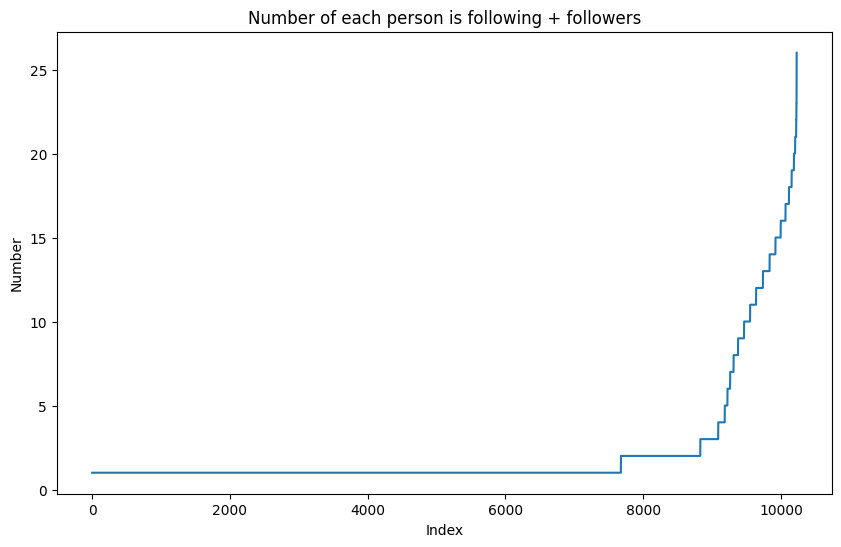

In [47]:
# Convert the lists to numpy arrays
in_degree = np.array(list(dict(G.in_degree()).values()))
out_degree = np.array(list(dict(G.out_degree()).values()))
# Add the arrays element-wise
in_out_degree = in_degree + out_degree
# Convert the in_out_degree back to a list
in_out_degree = sorted(in_out_degree.tolist())
plt.figure(figsize=(10, 6))
plt.plot(in_out_degree)
plt.title("Number of each person is following + followers")
plt.xlabel('Index')
plt.ylabel('Number')
# Save the figure
plt.savefig("imgs/num_total_followers_followees.png")
plt.show()

## 3. Data Preparation

1. Load node pairs and generate the graph

In [48]:
# Load the training dataset
df = pd.read_csv(config.TRAIN_CSV)
# Generate the graph with node pairs with label == 1
G = nx.from_pandas_edgelist(df[df['label'] == 1], "node1", "node2", create_using=nx.DiGraph())
# Check the number of nodes and edges in the original dataset
show_graph_info(G)

Metrices               Value
------------------  --------
Number of nodes     10230
Number of edges     12000
Average in-degree       1.17
Average out-degree      1.17


2. Generating missing edges from given graph (this will decrease the score)

In [49]:
# df = add_missing_edges(df, num_missing_edges=G.number_of_edges(), graph=G)

3. Split the dataset into training and validation sets

In [50]:
# Split the dataset into training and validation sets
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=996)

# Slice the features from the dataframe
X_train = df_train.iloc[:, :-1]
X_valid = df_valid.iloc[:, :-1]
# Slice the label from the dataframe
y_train = df_train.iloc[:, -1]
y_valid = df_valid.iloc[:, -1]

4. Check the distribution of the dataset

In [51]:
# Count the number of label of 0 and 1
train_bincounts = np.bincount(y_train)
test_bincounts = np.bincount(y_valid)

# Create a table with label and counts
table = [["Label 0", train_bincounts[0], test_bincounts[0]],
         ["Label 1", train_bincounts[1], test_bincounts[1]]]

# print the table using tabulate
print(tabulate(table, headers=["Label", "Train Count", "Test Count"]))

Label      Train Count    Test Count
-------  -------------  ------------
Label 0           9626          2374
Label 1           9574          2426


5. Plot the distribution of data

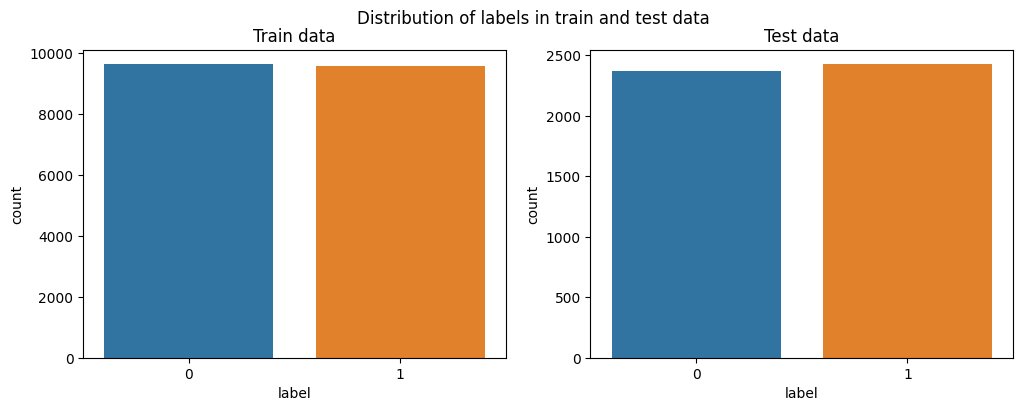

In [52]:
# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

# Plot the countplots
sns.countplot(x=y_train, ax=axs[0])
sns.countplot(x=y_valid, ax=axs[1])

# Set the titles
axs[0].set_title('Train data')
axs[1].set_title('Test data')

# Add a title for the entire plot
fig.suptitle('Distribution of labels in train and test data')

# Save the figure
plt.savefig("imgs/distribution_of_labels.png")

# Display the plot
plt.show()

## Model Building

1. Define Classifier 

In [53]:
clf = xgb.XGBClassifier(
    learning_rate=0.2, n_estimators=120, gamma=2.5, max_depth=25)

2. Train Model

In [54]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

3. Make prediction

In [55]:
y_pred = clf.predict(X_valid)

4. Check the confusion matrix and classification report

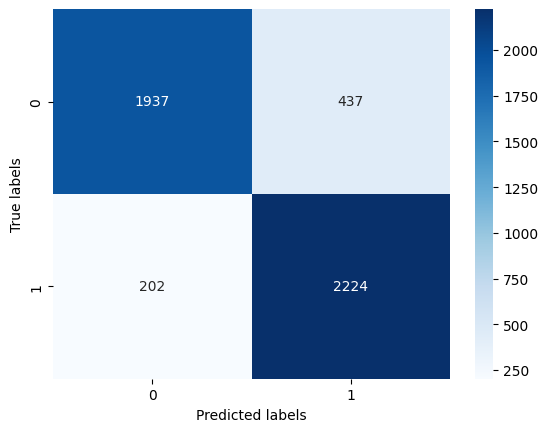

In [56]:
# assume the confusion matrix is stored in a variable called cm
cm = confusion_matrix(y_valid, y_pred)

# create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")

# add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
# Save the figure
plt.savefig("imgs/confusion_matrix.png")
plt.show()

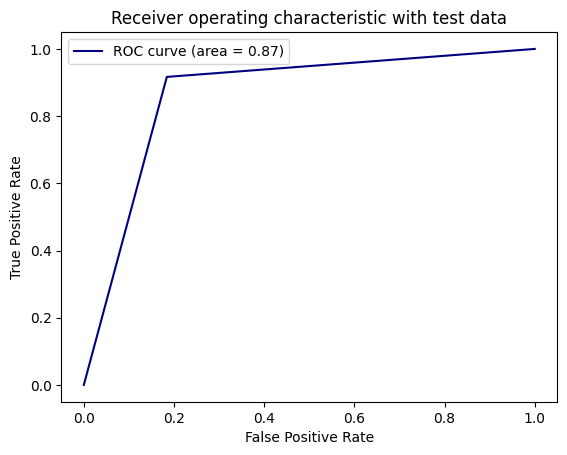

In [57]:
fpr, tpr, ths = roc_curve(y_valid, y_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
# Save the figure
plt.savefig("imgs/roc_curve.png")
plt.show()

In [58]:
report = classification_report(y_valid, y_pred, output_dict=False)

print(report)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2374
           1       0.84      0.92      0.87      2426

    accuracy                           0.87      4800
   macro avg       0.87      0.87      0.87      4800
weighted avg       0.87      0.87      0.87      4800



## 5. Make inferences on the public testing set

1. Make inferences

In [59]:
df_target = pd.read_csv(config.TEST_CSV)
# Generate the graph with node pairs
G = nx.from_pandas_edgelist(
    df_target, "node1", "node2", create_using=nx.DiGraph())
# Check the number of nodes and edges in the original dataset
show_graph_info(G)

X_target = df_target.iloc[:, 1:]

y_pred = clf.predict(X_target)


Metrices              Value
------------------  -------
Number of nodes     5512
Number of edges     5997
Average in-degree      1.09
Average out-degree     1.09


2. Export the predictions to `data/sample_submit.csv`

In [60]:
print(f"\nNumber of the prediction [0, 1]: {np.bincount(y_pred)}")

target_csv = config.TARGET_CSV

# Load the CSV file into a Pandas DataFrame
df_target = pd.read_csv(target_csv)

# Replace the values in the 'ans' column with the values from the Python list
df_target['ans'] = y_pred

# Save the updated DataFrame back to a CSV file, overwriting the original file
df_target.to_csv(target_csv, index=False)


Number of the prediction [0, 1]: [2656 3344]
